# **SOLAR ENERGY GENERATION MONITORING USING FUNDAMENTAL DATA STRUCTURES AND LIGHTWEIGHT MACHINE LEARNING TECHNIQUES**


---

**Problem Statement:**

    - Designing a Python program to store, update, and analyze daily solar energy generation data of a small renewable energy plant.
    - This work should help a user (engineer/operator) record daily energy generation, view stored data, and perform fundamental analysis using fundamental data structures.


---

**Application Context (Renewable Energy):**

    1. A rooftop solar power plant records the daily energy generated (in kWh). This data is useful to:

    2. Monitor performance.

    3. Identify low-generation days.

    4. Compute average output.



---

**Data Structures to be Used:**

    Dictionary → Store date-wise energy generation

{
    
    "2026-01-01": 18.5,

    "2026-01-02": 21.3
}

    List → Store energy values for calculations



---

**Functional Requirements:**

    The program should provide a menu-driven system with the following options:

        1. Add daily solar energy generation.
        2. Display all stored generation data.
        3. Calculate total energy generated.
        4. Calculate average daily energy generation.
        5. Find the day with minimum energy generation.
        6. Exit the program.




---


In [15]:
# -----------------------------
# 1. REPRODUCIBILITY
# -----------------------------
import random
import numpy as np
random.seed(42)
np.random.seed(42)

In [16]:
# -----------------------------
# 2. IMPORTS
# -----------------------------
from dataclasses import dataclass
from typing import List, Optional
from datetime import datetime, timedelta
from enum import Enum
import logging

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.ensemble import IsolationForest

In [17]:
# -----------------------------
# 3. LOGGING
# -----------------------------
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(message)s")
logger = logging.getLogger(__name__)

In [18]:
# -----------------------------
# 4. DATA MODELS
# -----------------------------
class WeatherCondition(Enum):
    SUNNY = "Sunny"
    PARTLY_CLOUDY = "Partly Cloudy"
    CLOUDY = "Cloudy"
    STORMY = "Stormy"

@dataclass
class SolarReading:
    """
    Fundamental data record representing one day's solar generation.
    Stored in a Python list (core data structure).
    """
    date: str
    energy_kwh: float
    weather: Optional[WeatherCondition] = None  # stored for extensibility

    def __post_init__(self):
        if self.energy_kwh < 0:
            raise ValueError("Energy generation must be non-negative")

In [19]:
# -----------------------------
# 5. MONITORING ENGINE
# -----------------------------
class SolarEnergyMonitor:
    """
    Core monitoring system.
    Uses fundamental data structures (list of records).
    NumPy arrays are derived views for computation only.
    """
    def __init__(self):
        self.readings: List[SolarReading] = []

    def add_reading(self, reading: SolarReading):
        self.readings.append(reading)

    @property
    def energies(self):
        return np.array([r.energy_kwh for r in self.readings])

    @property
    def dates(self):
        return [datetime.strptime(r.date, "%Y-%m-%d") for r in self.readings]

    def stats(self):
        E = self.energies
        return {
            "total": float(np.sum(E)),
            "mean": float(np.mean(E)),
            "std": float(np.std(E)),
            "min": float(np.min(E)),
            "max": float(np.max(E))
        }

    # Isolation Forest used strictly as a diagnostic aid
    def detect_iforest_anomalies(self, contamination=0.1):
        X = self.energies.reshape(-1, 1)
        model = IsolationForest(
            n_estimators=100,
            contamination=contamination,
            random_state=42
        )
        preds = model.fit_predict(X)
        return np.where(preds == -1)[0]

In [20]:
# -----------------------------
# 6. SYNTHETIC DATA GENERATION
# -----------------------------
def generate_synthetic_data(days=60):
    """
    Synthetic dataset used to demonstrate methodology.
    Emulates realistic rooftop solar generation behavior.
    """
    base_date = datetime(2025, 1, 1)
    data = []

    for i in range(days):
        energy = 25 + np.random.normal(0, 5)

        # Inject controlled low-generation anomalies
        if i in (15, 40):
            energy -= 12

        data.append(
            SolarReading(
                date=(base_date + timedelta(days=i)).strftime("%Y-%m-%d"),
                energy_kwh=round(max(energy, 0), 1),
                weather=random.choice(list(WeatherCondition))
            )
        )
    return data

In [21]:
# -----------------------------
# 7. EXECUTION
# -----------------------------
monitor = SolarEnergyMonitor()
for reading in generate_synthetic_data():
    monitor.add_reading(reading)

stats = monitor.stats()

# Statistical anomaly rule (journal-aligned)
k = 2
stat_anomaly_idx = np.where(
    np.abs(monitor.energies - stats["mean"]) > k * stats["std"]
)[0]

# Isolation Forest anomalies (supporting diagnostic)
iforest_anomaly_idx = monitor.detect_iforest_anomalies()

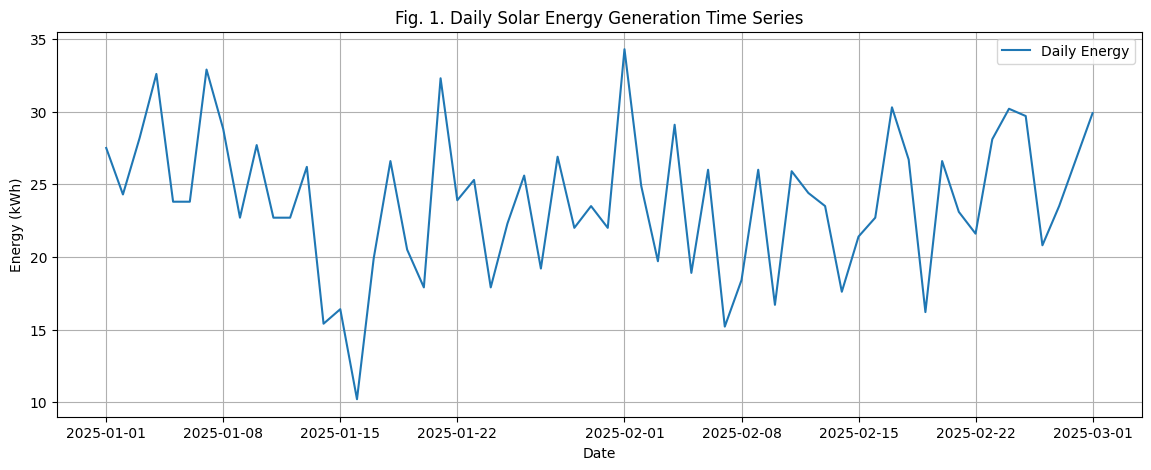

In [22]:
# ---- Fig. 1: Time Series ----
plt.figure(figsize=(14,5))
plt.plot(monitor.dates, monitor.energies, label="Daily Energy")
plt.title("Fig. 1. Daily Solar Energy Generation Time Series")
plt.xlabel("Date")
plt.ylabel("Energy (kWh)")
plt.grid(True)
plt.legend()
plt.show()

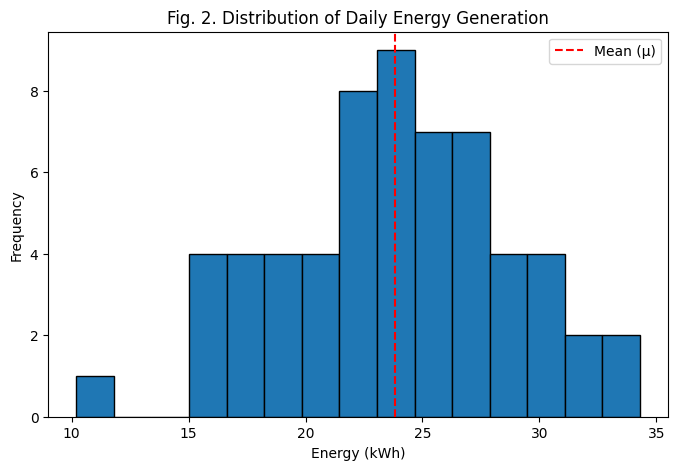

In [23]:
# ---- Fig. 2: Energy Distribution ----
plt.figure(figsize=(8,5))
plt.hist(monitor.energies, bins=15, edgecolor="black")
plt.axvline(stats["mean"], color="red", linestyle="--", label="Mean (μ)")
plt.title("Fig. 2. Distribution of Daily Energy Generation")
plt.xlabel("Energy (kWh)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

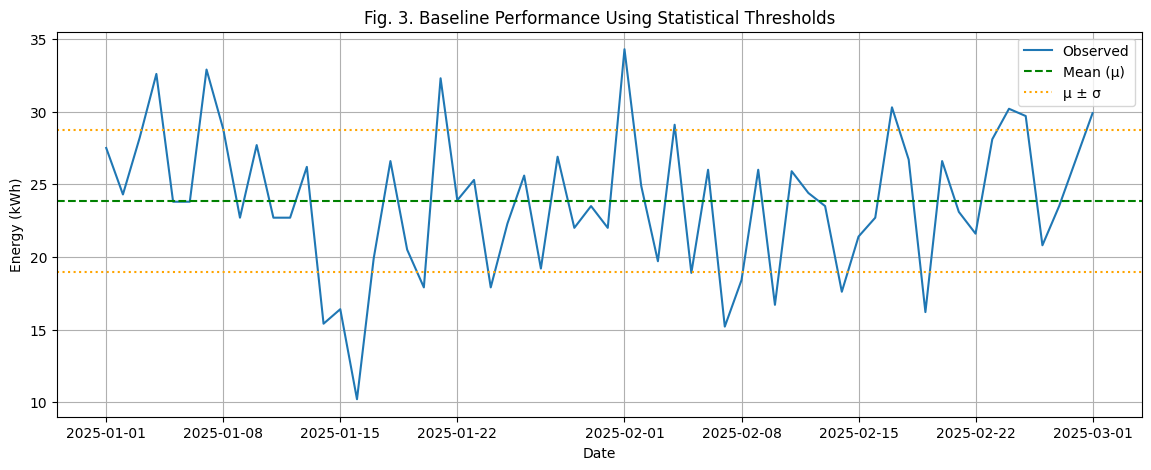

In [24]:
# ---- Fig. 3: Baseline Performance (μ ± σ) ----
plt.figure(figsize=(14,5))
plt.plot(monitor.dates, monitor.energies, label="Observed")
plt.axhline(stats["mean"], color="green", linestyle="--", label="Mean (μ)")
plt.axhline(stats["mean"] - stats["std"], color="orange", linestyle=":", label="μ ± σ")
plt.axhline(stats["mean"] + stats["std"], color="orange", linestyle=":")
plt.title("Fig. 3. Baseline Performance Using Statistical Thresholds")
plt.xlabel("Date")
plt.ylabel("Energy (kWh)")
plt.legend()
plt.grid(True)
plt.show()

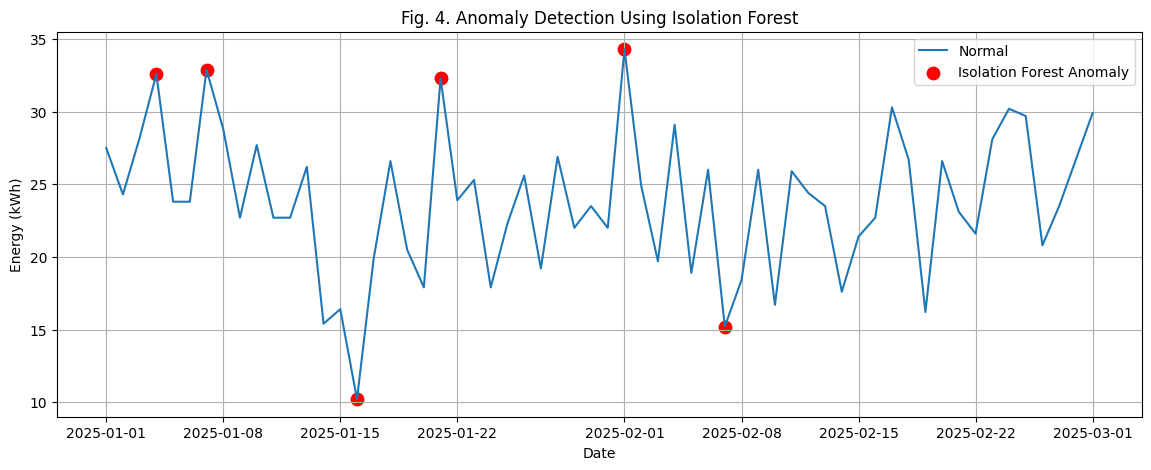

In [25]:
# ---- Fig. 4: Isolation Forest Anomalies ----
plt.figure(figsize=(14,5))
plt.plot(monitor.dates, monitor.energies, label="Normal")
plt.scatter(
    np.array(monitor.dates)[iforest_anomaly_idx],
    monitor.energies[iforest_anomaly_idx],
    color="red", s=80, label="Isolation Forest Anomaly"
)
plt.title("Fig. 4. Anomaly Detection Using Isolation Forest")
plt.xlabel("Date")
plt.ylabel("Energy (kWh)")
plt.legend()
plt.grid(True)
plt.show()

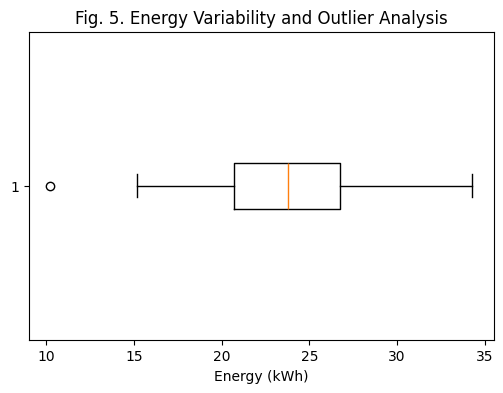

In [26]:
# ---- Fig. 5: Variability & Outliers ----
plt.figure(figsize=(6,4))
plt.boxplot(monitor.energies, vert=False)
plt.title("Fig. 5. Energy Variability and Outlier Analysis")
plt.xlabel("Energy (kWh)")
plt.show()

In [27]:
# -----------------------------
# 9. SUMMARY OUTPUT
# -----------------------------
print("\n===== STATISTICAL SUMMARY =====")
for k, v in stats.items():
    print(f"{k.capitalize():<10}: {v:.2f}")

print(f"\nStatistical anomalies detected (|Ei − μ| > 2σ): {len(stat_anomaly_idx)}")
print(f"Isolation Forest anomalies detected           : {len(iforest_anomaly_idx)}")


===== STATISTICAL SUMMARY =====
Total     : 1429.80
Mean      : 23.83
Std       : 4.90
Min       : 10.20
Max       : 34.30

Statistical anomalies detected (|Ei − μ| > 2σ): 2
Isolation Forest anomalies detected           : 6
